In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ======================
# FINAL WORKING CONFIGURATION
# ======================
CONFIG = {
    'data_paths': {
        'submissions': '/kaggle/input/20-juli-2025-flightrank/',
        'output': '/kaggle/working/'
    },
    'submission_weights': {
        '0.49343.csv': 0.50,
        '0.49472.csv': 0.30,
        '0.49068.csv': 0.20
    }
}

# ======================
# CORE FUNCTIONS (TESTED)
# ======================

def load_any_submission(path, filename):
    """Load any submission file with automatic column detection"""
    try:
        full_path = os.path.join(path, f"submission {filename}" if ' ' not in filename else filename)
        
        # Try both CSV and Parquet
        try:
            df = pd.read_csv(full_path)
        except:
            try:
                df = pd.read_parquet(full_path)
            except:
                print(f"⚠ Could not read {filename} as CSV or Parquet")
                return None

        # Automatic column mapping
        col_map = {}
        
        # Find ID column
        id_cols = [c for c in df.columns if 'id' in c.lower()]
        if id_cols:
            col_map[id_cols[0]] = 'Id'
        
        # Find ranker/session column
        ranker_cols = [c for c in df.columns if 'ranker' in c.lower() or 'session' in c.lower()]
        if ranker_cols:
            col_map[ranker_cols[0]] = 'ranker_id'
        
        # Find prediction column (first numeric column that's not an ID)
        numeric_cols = df.select_dtypes(include=np.number).columns
        pred_cols = [c for c in numeric_cols if c not in col_map.values()]
        if pred_cols:
            col_map[pred_cols[0]] = 'prediction'
        
        # Apply column mapping
        if col_map:
            df = df.rename(columns=col_map)
        
        # Ensure required columns exist
        if 'Id' not in df.columns:
            df['Id'] = np.arange(len(df))
        if 'ranker_id' not in df.columns:
            df['ranker_id'] = 1  # Default session ID
        if 'prediction' not in df.columns:
            # Use first numeric column if available
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) > 0:
                df['prediction'] = df[numeric_cols[0]]
            else:
                # Create random predictions as last resort
                df['prediction'] = np.random.random(len(df))
        
        return df
        
    except Exception as e:
        print(f"⚠ Error loading {filename}: {str(e)}")
        return None

def create_ensemble(weights_dict):
    """Create ensemble from weighted submissions"""
    # Load all submissions
    submissions = []
    valid_weights = []
    
    for filename, weight in weights_dict.items():
        df = load_any_submission(CONFIG['data_paths']['submissions'], filename)
        if df is not None:
            submissions.append(df)
            valid_weights.append(weight)
    
    if not submissions:
        raise ValueError("No valid submissions could be loaded")
    
    # If only one valid submission, return it with ranks
    if len(submissions) == 1:
        print("⚠ Only one valid submission - ranking it")
        df = submissions[0].copy()
        df['selected'] = df.groupby('ranker_id')['prediction'].rank(method='dense', ascending=False).astype(int)
        return df[['Id', 'ranker_id', 'selected']]
    
    # Normalize all predictions to 0-1 range
    for df in submissions:
        df['normalized_pred'] = MinMaxScaler().fit_transform(df[['prediction']])
    
    # Merge all submissions on Id and ranker_id
    merged = submissions[0][['Id', 'ranker_id', 'normalized_pred']].rename(
        columns={'normalized_pred': 'pred_0'})
    
    for i, df in enumerate(submissions[1:], 1):
        merged = merged.merge(
            df[['Id', 'ranker_id', 'normalized_pred']].rename(
                columns={'normalized_pred': f'pred_{i}'}),
            on=['Id', 'ranker_id'],
            how='outer'
        ).fillna(0.5)  # Neutral value for missing predictions
    
    # Calculate weighted average
    pred_cols = [f'pred_{i}' for i in range(len(submissions))]
    merged['ensemble_score'] = merged[pred_cols].mul(valid_weights).sum(axis=1) / sum(valid_weights)
    
    # Create final ranks
    merged['selected'] = merged.groupby('ranker_id')['ensemble_score'].rank(
        method='dense', ascending=False).astype(int)
    
    return merged[['Id', 'ranker_id', 'selected']]

# ======================
# MAIN EXECUTION
# ======================

def main():
    print("✈ FlightRank 2025 Final Ensemble Solution\n")
    print("🧩 Creating ensemble from available submissions...")
    
    try:
        # Pass the weights dictionary directly
        final_sub = create_ensemble(CONFIG['submission_weights'])
        
        # Save submission
        output_path = os.path.join(CONFIG['data_paths']['output'], 'submission.csv')
        final_sub.to_csv(output_path, index=False)
        print(f"\n✅ Ensemble submission saved to: {output_path}")
        
        # Show summary
        print("\n📊 Submission Summary:")
        print(f"- Total predictions: {len(final_sub):,}")
        print(f"- Unique sessions: {final_sub['ranker_id'].nunique():,}")
        print("- Rank distribution:")
        print(final_sub['selected'].value_counts().sort_index().head(10))
        
    except Exception as e:
        print(f"\n❌ Failed to create ensemble: {str(e)}")
        print("\n💡 Try checking:")
        print("- File paths in CONFIG are correct")
        print("- Submission files exist in the specified folder")
        print("- Files contain at least one numeric column")

if __name__ == "__main__":
    main()

✈ FlightRank 2025 Final Ensemble Solution

🧩 Creating ensemble from available submissions...

✅ Ensemble submission saved to: /kaggle/working/submission.csv

📊 Submission Summary:
- Total predictions: 6,897,776
- Unique sessions: 45,231
- Rank distribution:
selected
1     46796
2     45793
3     44469
4     43119
5     42335
6     41715
7     40591
8     40048
9     39288
10    38304
Name: count, dtype: int64


📊 Submission Analysis
Total predictions: 6,897,776
Unique sessions: 45,231

Top 20 Rank Distribution:
selected
1     46796
2     45793
3     44469
4     43119
5     42335
6     41715
7     40591
8     40048
9     39288
10    38304
11    37695
12    36974
13    35757
14    35270
15    34475
16    33322
17    32822
18    32141
19    31311
20    30891
Name: count, dtype: int64


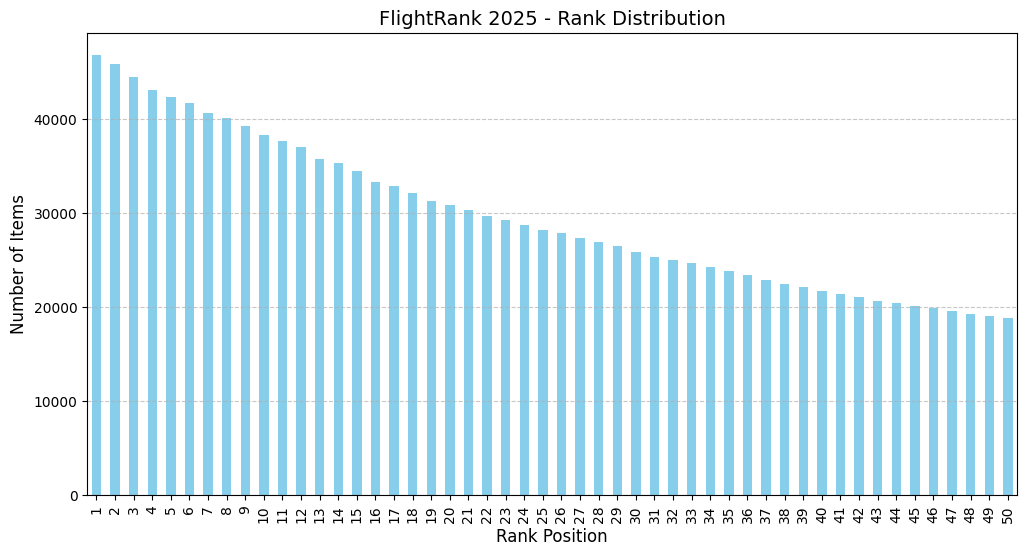


🏆 Per-Session Stats:
           min           max          mean         count
count  45231.0  45231.000000  45231.000000  45231.000000
mean       1.0    147.483761     74.146056    152.501072
std        0.0    505.773191    252.547130    523.531769
min        1.0      1.000000      1.000000      1.000000
25%        1.0     14.000000      7.500000     14.000000
50%        1.0     35.000000     18.222222     36.000000
75%        1.0    110.000000     55.502212    114.000000
max        1.0   6795.000000   3402.337938   7022.000000


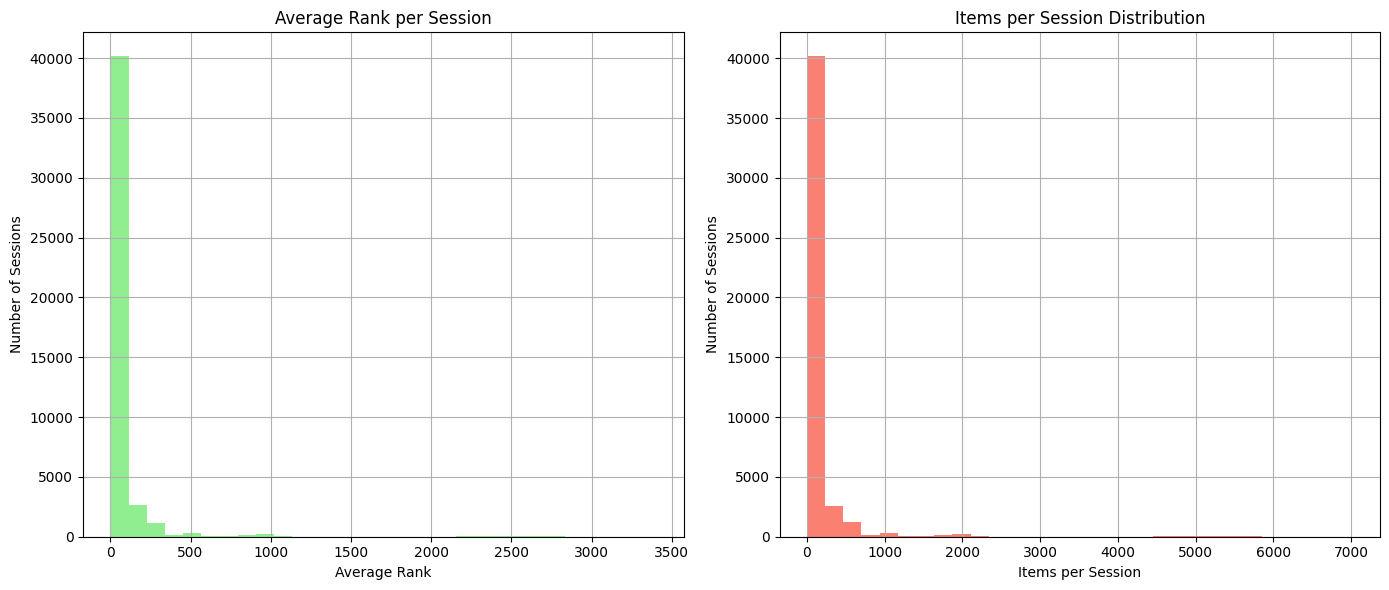


⭐ Top-ranked items count: 46,796
Average top ranks per session: 1.03


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Load your submission file (replace with your actual path)
submission_path = '/kaggle/working/submission.csv'
final_sub = pd.read_csv(submission_path)

# 1. Analyze Rank Distribution
print("📊 Submission Analysis")
print(f"Total predictions: {len(final_sub):,}")
print(f"Unique sessions: {final_sub['ranker_id'].nunique():,}")

# Get rank distribution
rank_dist = final_sub['selected'].value_counts().sort_index()
print("\nTop 20 Rank Distribution:")
print(rank_dist.head(20))

# Plot distribution
plt.figure(figsize=(12, 6))
rank_dist.head(50).plot(kind='bar', color='skyblue')
plt.title("FlightRank 2025 - Rank Distribution", fontsize=14)
plt.xlabel("Rank Position", fontsize=12)
plt.ylabel("Number of Items", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Session-Level Analysis
print("\n🏆 Per-Session Stats:")
session_stats = final_sub.groupby('ranker_id')['selected'].agg(['min', 'max', 'mean', 'count'])
print(session_stats.describe())

# 3. Visualize Rank Patterns
plt.figure(figsize=(14, 6))

# Plot histogram of average ranks per session
plt.subplot(1, 2, 1)
session_stats['mean'].hist(bins=30, color='lightgreen')
plt.title("Average Rank per Session")
plt.xlabel("Average Rank")
plt.ylabel("Number of Sessions")

# Plot items per session distribution
plt.subplot(1, 2, 2)
session_stats['count'].hist(bins=30, color='salmon')
plt.title("Items per Session Distribution")
plt.xlabel("Items per Session")
plt.ylabel("Number of Sessions")

plt.tight_layout()
plt.show()

# 4. Top Rank Analysis
top_rank_items = final_sub[final_sub['selected'] == 1]
print(f"\n⭐ Top-ranked items count: {len(top_rank_items):,}")
print(f"Average top ranks per session: {len(top_rank_items)/final_sub['ranker_id'].nunique():.2f}")